In [11]:
!pip install casadi

import sys
sys.path.insert(0, '../python/casadi_f16')
import f16
import control
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

from analysis import loop_analysis, rlocus, bode

plt.rcParams['figure.figsize'] = (10, 10)

# Roll Autopilot Design

* See Roll Autopilot design example in section 4.6 of Stevens and Lewis.
* Homework 1: Due 8/30 @  11 pm: Trim the F16 model around a VT=550 ft/s, 20 deg/s yaw rate turn.
* Find the A, B, C, D matrices for the state space model.
* Find the transfer function for the aileron to roll rate (P).
* Design a PID controller attempting to meet the following specifications
    * Maximum overshoot: 20%
    * Rise time: 0.1 second
    * Settling time 1 second
* Simulate and plot the response of your controlled system and the linear model for a step response in roll rate of 10 deg/s and 100 deg/s. How do the nonlinear and linear responses compare?
* Using git, fork aae497-f16 on github. Complete the homework. Submit your homework via pull request on aae497-f16.

## Definitions

In [12]:
# Trimming f16
p = f16.Parameters()
x0, u0 = f16.trim(x=f16.State(VT=550), p=p, phi_dot=0, theta_dot=0, psi_dot=np.deg2rad(20), gam=0)

# Control Function
def f_control(t, x):
    return f16.Control(
        thtl=u0.thtl,
        ail_cmd_deg=u0.ail_cmd_deg,
        elv_cmd_deg=u0.elv_cmd_deg,
        rdr_cmd_deg=u0.rdr_cmd_deg)


## Simulation

In [13]:
def select(n, i):
    D = np.zeros((1, n))
    D[0, i] = 1
    return control.ss([], [], [], D)
ss = f16.linearize(x0, u0, p)
s = control.tf([1, 0], [0, 1])
G = -(180/np.pi)*ss.sub_system(x=['alpha', 'Q', 'elv_deg'],
                  u=['elv_cmd_deg'], y=['alpha', 'Q']).to_control()
sys3 = control.feedback(G, 0.2*10/(s+10)*select(2, 0))
sys3

A = [[-1.15177248e+00  9.03393838e-01 -2.34025343e-03  0.00000000e+00]
 [ 3.98296410e+00 -1.48073989e+00 -2.35589930e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.02020000e+01  2.31497868e+03]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e+01]]

B = [[    0.        ]
 [    0.        ]
 [-1157.48933772]
 [    0.        ]]

C = [[1. 0. 0. 0.]
 [0. 1. 0. 0.]]

D = [[0.]
 [0.]]

3 states have been removed from the model


[-21, 0, -8, 8]

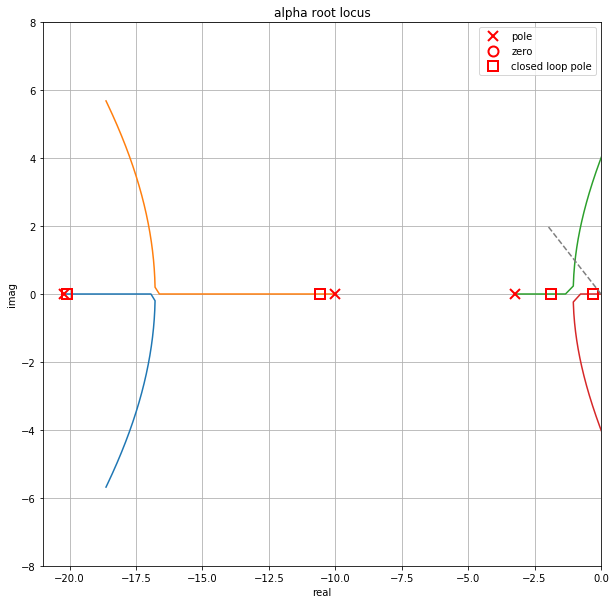

In [14]:
from analysis import rlocus
H = (10/(s+10))*select(2, 0)
plt.figure()
kalpha = 0.2
rlocus('alpha', control.minreal(H*G), kvect=np.linspace(0, 10, 1000), k=kalpha);
plt.plot([0, -2], [0, 2], '--')
plt.axis([-21, 0, -8, 8])

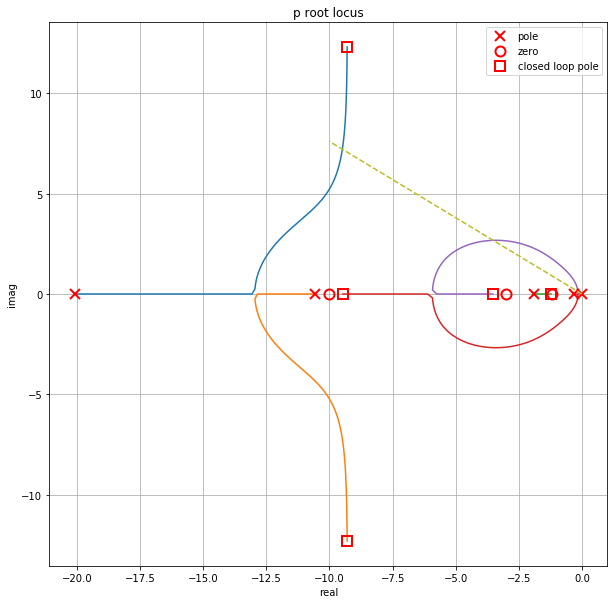

In [15]:
plt.figure()
sys3 = control.feedback(G, kalpha*(10/(s+10))*select(2, 0))
rlocus('p', (s+3)/s*sys3[1, 0], kvect=np.linspace(0, 1, 1000), k=1)
plt.plot([0, -10], [0, 10*np.cos(0.707)], '--')

## PI Controller to modify rise time and overshoot

H_PI =  
2.5 s + 0.5
-----------
     s

G0 =  
      681.7 s^3 + 7766 s^2 + 9648 s + 1624
-------------------------------------------------
s^5 + 32.83 s^4 + 279.6 s^3 + 480.1 s^2 + 118.4 s



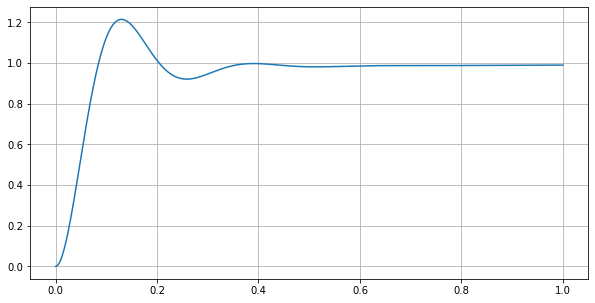

1.2146981138975048


In [58]:
P = 2.5
I = 0.5
H_PI = P + I * (1/ s)
print('H_PI = ',H_PI)

G0 = H_PI*sys3[1, 0]
print('G0 = ',G0)

Gc = control.feedback(G0, 1)

t, y = control.step_response(Gc, T=np.linspace(0, 1, 1000))
plt.figure(figsize=(10, 5))
plt.plot(t, 1*y)
plt.grid()
plt.show()
print(max(y))

# The linear response will look less and less like the system as the angle increases.